In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('diabetes.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

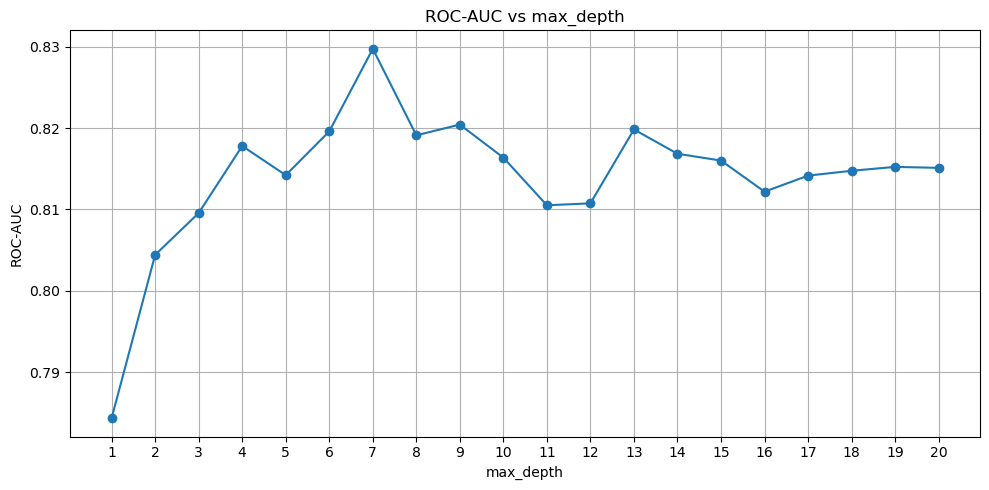

Оптимальная глубина: 7, ROC-AUC = 0.8297


In [7]:
max_depths = range(1, 21)
roc_auc_rf_depth = []

for d in max_depths:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=d,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_test)[:, 1]
    roc_auc_rf_depth.append(roc_auc_score(y_test, y_proba))

plt.figure(figsize=(10, 5))
plt.plot(max_depths, roc_auc_rf_depth, marker='o')
plt.title('ROC-AUC vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC')
plt.grid(True)
plt.xticks(max_depths)
plt.tight_layout()
plt.show()

best_depth_rf = max_depths[np.argmax(roc_auc_rf_depth)]
print(f"Оптимальная глубина: {best_depth_rf}, ROC-AUC = {max(roc_auc_rf_depth):.4f}")

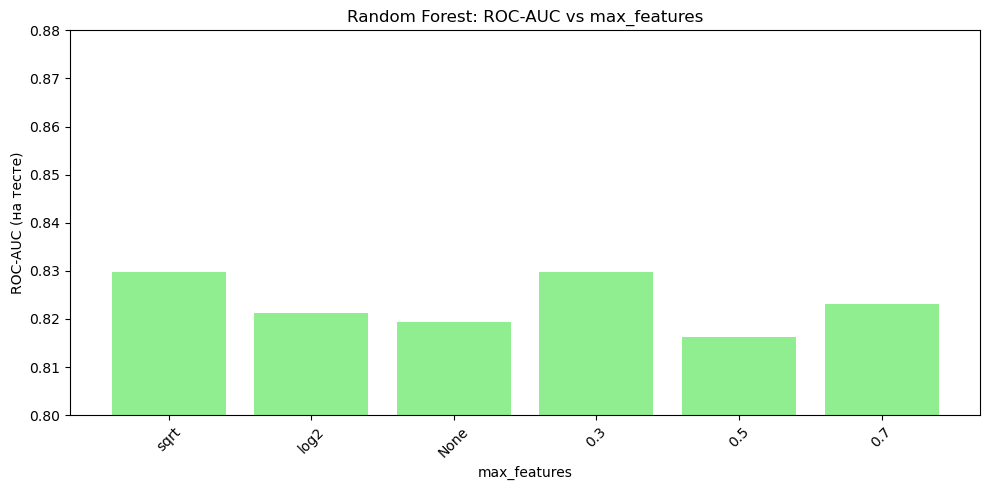

Лучший max_features: sqrt, ROC-AUC = 0.8297


In [15]:
max_features_opts = ['sqrt', 'log2', None, 0.3, 0.5, 0.7]
roc_auc_rf_mf = []

for mf in max_features_opts:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=best_depth_rf,
        max_features=mf,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_test)[:, 1]
    roc_auc_rf_mf.append(roc_auc_score(y_test, y_proba))

plt.figure(figsize=(10, 5))
plt.bar([str(m) for m in max_features_opts], roc_auc_rf_mf, color='lightgreen')
plt.title('Random Forest: ROC-AUC vs max_features')
plt.xlabel('max_features')
plt.ylabel('ROC-AUC (на тесте)')
plt.xticks(rotation=45)
plt.ylim(0.8, 0.88)
plt.tight_layout()
plt.show()

best_mf_rf = max_features_opts[np.argmax(roc_auc_rf_mf)]
print(f"Лучший max_features: {best_mf_rf}, ROC-AUC = {max(roc_auc_rf_mf):.4f}")

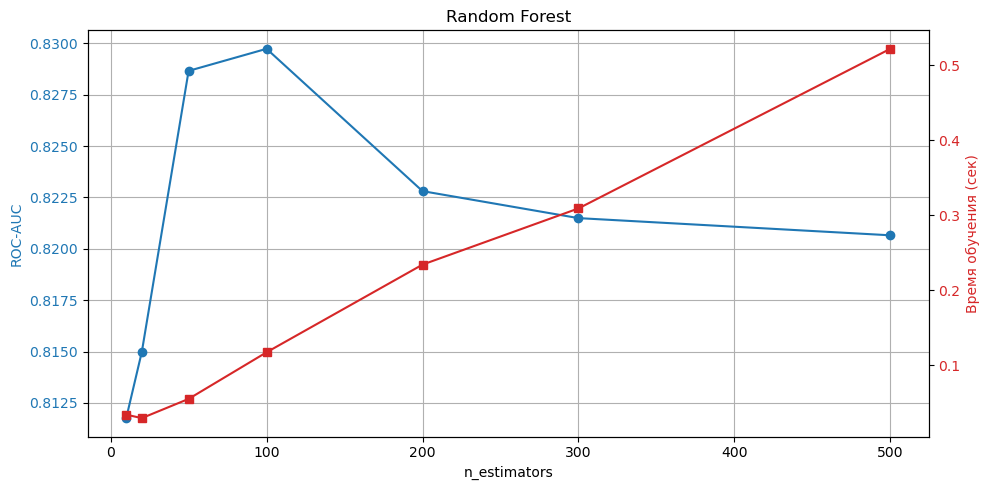

Лучшее число деревьев: 100
ROC-AUC: 0.8297, Время обучения: 0.12 сек


In [23]:
n_estimators_list = [10, 20, 50, 100, 200, 300, 500]
roc_auc_rf_ne = []
train_times = []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_depth_rf,
        max_features=best_mf_rf,
        random_state=42,
        n_jobs=-1
    )
    start = time.time()
    rf.fit(X_train, y_train)
    end = time.time()
    
    y_proba = rf.predict_proba(X_test)[:, 1]
    roc_auc_rf_ne.append(roc_auc_score(y_test, y_proba))
    train_times.append(end - start)

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('ROC-AUC', color=color)
ax1.plot(n_estimators_list, roc_auc_rf_ne, marker='o', color=color, label='ROC-AUC')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Время обучения (сек)', color=color)
ax2.plot(n_estimators_list, train_times, marker='s', color=color, label='Время')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Random Forest')
fig.tight_layout()
plt.show()

best_n_rf = n_estimators_list[np.argmax(roc_auc_rf_ne)]
print(f"Лучшее число деревьев: {best_n_rf}")
print(f"ROC-AUC: {max(roc_auc_rf_ne):.4f}, Время обучения: {train_times[np.argmax(roc_auc_rf_ne)]:.2f} сек")

In [145]:
xgb_params = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'n_estimators': 35,
    'subsample': 0.7,
    'reg_alpha': 1,
    'reg_lambda': 1
}

In [147]:
xgb = XGBClassifier(**xgb_params)
start = time.time()
xgb.fit(X_train, y_train)
xgb_time = time.time() - start

y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, y_proba_xgb)

print("XGBoost (ручная настройка)")
print(f"ROC-AUC: {xgb_auc:.4f}")
print(f"Время обучения: {xgb_time:.2f} сек")
print("\nКлассификационный отчёт:")
print(classification_report(y_test, xgb.predict(X_test)))

XGBoost (ручная настройка)
ROC-AUC: 0.8259
Время обучения: 0.03 сек

Классификационный отчёт:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       125
           1       0.71      0.61      0.66        67

    accuracy                           0.78       192
   macro avg       0.76      0.74      0.74       192
weighted avg       0.77      0.78      0.77       192



In [149]:
rf_best = RandomForestClassifier(
    n_estimators=best_n_rf,
    max_depth=best_depth_rf,
    max_features=best_mf_rf,
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train, y_train)
rf_auc = roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1])

print("\nСравнение моделей")
print(f"Random Forest: ROC-AUC = {rf_auc:.4f}")
print(f"XGBoost       : ROC-AUC = {xgb_auc:.4f}")
print(f"RF время      : {train_times[np.argmax(roc_auc_rf_ne)]:.2f} сек")
print(f"XGBoost время : {xgb_time:.2f} сек")


Сравнение моделей
Random Forest: ROC-AUC = 0.8297
XGBoost       : ROC-AUC = 0.8259
RF время      : 0.12 сек
XGBoost время : 0.03 сек


Random Forest показал чуть лучшее качество, но XGBoost обучается в 4 раза быстрее. Разница в качестве при этом почти незаметна. Поэтому для этой задачи можно использовать обе модели, но Random Forest для максимальной точности, а XGBoost для более скорого обучения.